In [21]:
push!(LOAD_PATH, pwd())
using LightGraphs, IndirectRec, GraphConnectivityTheory,GraphCreation
using PyCall, PyPlot, Distributions

In [217]:
N = 100

g = Graph(N,round(Int,N*(N-1)/2))

function produce_clique_graph(N,c::Float64)
    h = erdos_renyi(N,c)
    new_v = add_vertex!(h)
    vert = vertices(h)
    for w in vertices(h)
        if new_v != w
            add_edge!(h,new_v,w)
        end
    end
    h
end


h = produce_clique_graph(N,0.4) 

{101, 2080} undirected graph

In [220]:
change = true
p_range = 0.0:0.025:0.5
c = 0.1
P_range = similar(p_range)
if change
    P_clique_range = similar(p_range)*0
end
P_th_clique_range = similar(p_range)*0
P_th_range = similar(p_range)
num_trials = 100
num_trials_clique = 40

for (i,p) in enumerate(p_range)
#      P_range[i] = get_p_known_percolation(g,p,N,num_trials)[end]
#     P_th_range[i] = convert(Float64,get_p_known_percolation_theory(N,1,p))
    P_range[i] = convert(Float64,get_p_known_percolation_theory(N+1,1,p))
    P_th_range[i] = convert(Float64,get_p_known_percolation_theory(N+1,1,p*c))
    P_th_clique_range[i] = get_p_known_clique_t(N,c,p)# convert(Float64,get_p_known_percolation_theory(N+1,1,p))

    if change
        for j = 1:num_trials_clique
            h = produce_clique_graph(N,c)
            P_clique_range[i] += get_p_known_percolation(h,p,N,num_trials)[1][end] 
        end
        P_clique_range[i] /= num_trials_clique
    end

end

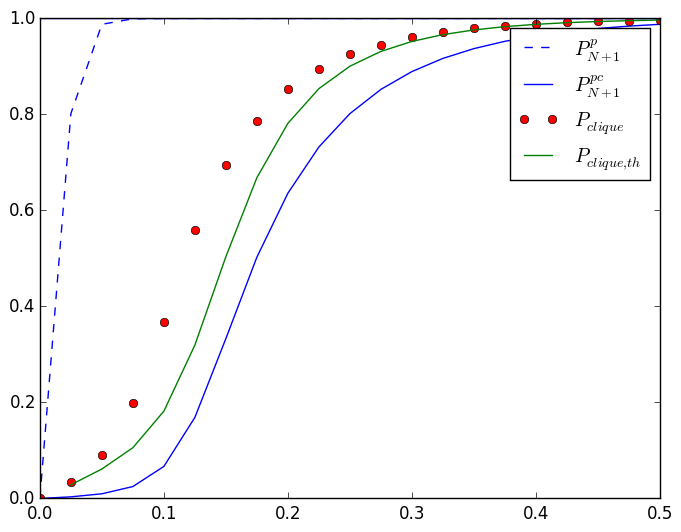

PyObject <matplotlib.legend.Legend object at 0x312453350>

In [222]:
plot(p_range,P_range,"--b",label=L"P_{N+1}^{p}")
plot(p_range,P_th_range,label=L"P_{N+1}^{p c}")
plot(p_range,P_clique_range,"or",label=L"P_{clique}")
plot(p_range,P_th_clique_range,label=L"P_{clique,th}")
# f(x) = 1 - (1 - x).^(N/2)
# plot(p_range,f(p_range)./f(c*p_range), label=L"\frac{p(1-p)}{p c (1 - p c)}")
axhline(1.0)
legend(loc = "upper right")

We model the clique of friends as an Erdos-Renyi random graph with $k$ nodes and edge probability $c$.

The ego node is connected to every one of the nodes of the Erdos Renyi graph. The probability that it is connected to a given node is
$p + (1 - p)*(1 - (1 - p*p_{perc})^k)$

## TODO why does p known clique not work?

In [3]:
function get_p_known_clique(k::Int,c::Float64,p::Float64)
    N = k 
    p_c = p*c
    p_perc = percolation_erdos_renyi(N+1,p_c)
    return p + (1-p)*p*(p_perc - p_c)/((1-p_c)*p_c) 
end
    

get_p_known_clique (generic function with 1 method)

In [209]:
function get_p_known_clique_t(k::Int,c::Float64,p::Float64)
    N = k 
    p_c = p*c
    p_perc = percolation_erdos_renyi(N+1,p_c)
    p_perc_higher = percolation_erdos_renyi(N+1,p)
    f(x) = (1 - (1 - x)^(N-1))
#     return p + (1-p)*(p_perc - p_c)/((1-p_c)) 
#     return (1-p)*p_perc + p*p_perc_higher
    return p  + (1 - p)/(1 - p_c)*(p_perc - p_c)*f(p)/f(p_c)
end
    

get_p_known_clique_t (generic function with 1 method)

In [158]:
function prefac(p,c)
    p_c = p*c
    return (1 + p_c - p) / (c)
end

prefac (generic function with 1 method)

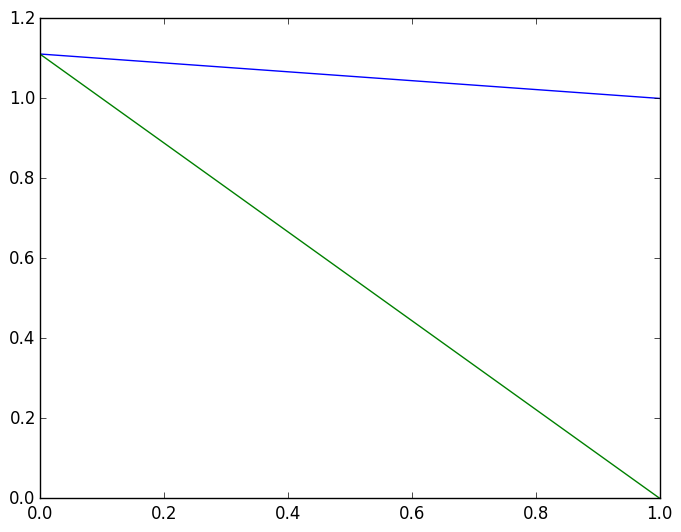

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32276d490>

In [100]:
c = 0.9
pr = 0:0.01:1
plot(pr,prefac(pr,c))
plot(pr,1/c - pr * 1/c)